In [19]:
import os
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# keras import
from keras.applications import VGG16, ResNet50, Xception
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input

In [2]:
disease_types = ['COVID', 'non-COVID']
data_dir = 'D:\Academics\SEM 5\signal processing\endsem\sem-5\CT_COVID'

In [3]:
train_dir = os.path.join(data_dir)
train_data = []

for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])

train

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID
...,...,...,...
2477,non-COVID/Non-Covid (995).png,1,non-COVID
2478,non-COVID/Non-Covid (996).png,1,non-COVID
2479,non-COVID/Non-Covid (997).png,1,non-COVID
2480,non-COVID/Non-Covid (998).png,1,non-COVID


2) Read and Preprocess the Dataframe

* Read the Images
* Convert the Images into the standard size of (64 x 64)
* Create numpy arrays for input/output X_Train & Y_Train
* Normalize the RGB values by dividing with 255.

In [4]:
IMAGE_SIZE = 64

def read_image(filepath):
	return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
	return cv2.resize(image.copy(), image_size,
					interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

# tqdm displays current iterations and time took for completion of loop
for i, file in tqdm(enumerate(train['File'].values)):
	image = read_image(file)
	if image is not None:
		X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# contains all the covid and non-covid CT-scans
X_Train = X_train / 255.

Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)


2482it [00:14, 172.30it/s]


3) Split the Dataset into Train/Validation

* Split into Train, Validation datasets
* Select split percentage & random state accordingly

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)


In [6]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

### Using ResNet 50

In [7]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [8]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0     

C:\Users\rchar\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/100


C:\Users\rchar\AppData\Local\Temp\ipykernel_26524\391079107.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


31/31 [==============================] - ETA: 0s - loss: 1.2068 - accuracy: 0.5450
Epoch 1: val_loss improved from inf to 10.12463, saving model to ResNet50_Model.hdf5
31/31 [==============================] - 80s 2s/step - loss: 1.2068 - accuracy: 0.5450 - val_loss: 10.1246 - val_accuracy: 0.4809 - lr: 0.0030
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 1.0435 - accuracy: 0.6013
Epoch 2: val_loss did not improve from 10.12463
31/31 [==============================] - 71s 2s/step - loss: 1.0435 - accuracy: 0.6013 - val_loss: 29.3689 - val_accuracy: 0.4809 - lr: 0.0030
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.6434
Epoch 3: val_loss did not improve from 10.12463
31/31 [==============================] - 68s 2s/step - loss: 0.8845 - accuracy: 0.6434 - val_loss: 28.2704 - val_accuracy: 0.4809 - lr: 0.0030
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.8294 - accuracy: 0.6575
Epoch 4: val_loss did 

Epoch 28/100
31/31 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8308
Epoch 28: val_loss improved from 0.79088 to 0.70320, saving model to ResNet50_Model.hdf5
31/31 [==============================] - 67s 2s/step - loss: 0.3735 - accuracy: 0.8308 - val_loss: 0.7032 - val_accuracy: 0.6781 - lr: 7.2030e-04
Epoch 29/100
31/31 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8334
Epoch 29: val_loss did not improve from 0.70320
31/31 [==============================] - 66s 2s/step - loss: 0.3741 - accuracy: 0.8334 - val_loss: 0.7347 - val_accuracy: 0.6962 - lr: 7.2030e-04
Epoch 30/100
31/31 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.8365
Epoch 30: val_loss improved from 0.70320 to 0.64877, saving model to ResNet50_Model.hdf5
31/31 [==============================] - 67s 2s/step - loss: 0.3700 - accuracy: 0.8365 - val_loss: 0.6488 - val_accuracy: 0.7304 - lr: 7.2030e-04
Epoch 31/100
31/31 [============================

Epoch 54/100
31/31 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8600
Epoch 54: val_loss did not improve from 0.26108
31/31 [==============================] - 67s 2s/step - loss: 0.3372 - accuracy: 0.8600 - val_loss: 0.2853 - val_accuracy: 0.8833 - lr: 7.2030e-04
Epoch 55/100
31/31 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8704
Epoch 55: val_loss improved from 0.26108 to 0.25929, saving model to ResNet50_Model.hdf5
31/31 [==============================] - 67s 2s/step - loss: 0.3097 - accuracy: 0.8704 - val_loss: 0.2593 - val_accuracy: 0.8853 - lr: 7.2030e-04
Epoch 56/100
31/31 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8657
Epoch 56: val_loss improved from 0.25929 to 0.25606, saving model to ResNet50_Model.hdf5
31/31 [==============================] - 67s 2s/step - loss: 0.3113 - accuracy: 0.8657 - val_loss: 0.2561 - val_accuracy: 0.8913 - lr: 7.2030e-04
Epoch 57/100
31/31 [============================

Epoch 80/100
31/31 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8740
Epoch 80: val_loss did not improve from 0.22664
31/31 [==============================] - 66s 2s/step - loss: 0.2859 - accuracy: 0.8740 - val_loss: 0.2274 - val_accuracy: 0.9095 - lr: 1.7294e-04
Epoch 81/100
31/31 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8886
Epoch 81: val_loss did not improve from 0.22664
31/31 [==============================] - 66s 2s/step - loss: 0.2710 - accuracy: 0.8886 - val_loss: 0.2358 - val_accuracy: 0.9095 - lr: 1.7294e-04
Epoch 82/100
31/31 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8777
Epoch 82: val_loss did not improve from 0.22664
31/31 [==============================] - 66s 2s/step - loss: 0.2925 - accuracy: 0.8777 - val_loss: 0.2302 - val_accuracy: 0.9115 - lr: 1.7294e-04
Epoch 83/100
31/31 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8834
Epoch 83: val_loss did not improve

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

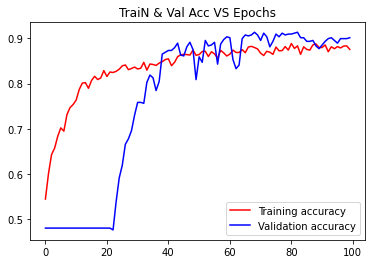

<Figure size 432x288 with 0 Axes>

In [13]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

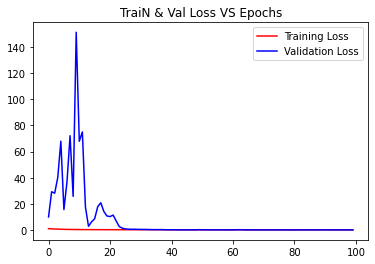

<Figure size 432x288 with 0 Axes>

In [14]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()
     

In [15]:
model.load_weights("ResNet50_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 2s 148ms/step - loss: 0.2266 - accuracy: 0.9074
Test Loss: 0.2266443967819214
Test accuracy: 90.74446558952332


16/16 [==============================] - 2s 145ms/step


Text(0.5, 1.0, 'Confusion Matrix')

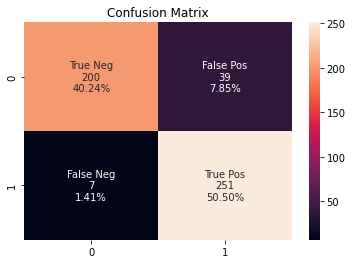

In [20]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")